In [1]:
!pip install speechbrain torchaudio torch pinecone

In [2]:
import os
import numpy as np
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier
import pinecone
import uuid
from typing import List, Union, Dict, Any

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
/tmp/ipython-input-2-7160307.py:5: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


In [3]:
PINECONE_API_KEY = "pcsk_2yzKnb_DusX4M95CU1KTjQxkZFPdYWbtFghFc7kUD2cHzpUT4hWPLmMbPgEgT5NgoX3Fib"
PINECONE_ENV = "us-east-1"
INDEX_NAME = "voice-biometrics"
EMBEDDING_DIM = 192  # Matches ECAPA-TDNN output (spkrec-ecapa-voxceleb)
UPSERT_BATCH_SIZE = 100

In [4]:
def audio_to_embedding(audio_path):
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")

    try:
        # Load the pretrained model
        model = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            savedir="pretrained_models/spkrec-ecapa-voxceleb"
        )

        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample to 16kHz if necessary
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        # Pad audio if shorter than 1 second
        min_length = 16000
        if waveform.shape[1] < min_length:
            padding = min_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Generate embedding
        embedding = model.encode_batch(waveform)

        return embedding.squeeze().numpy()

    except Exception as e:
        raise RuntimeError(f"Error processing audio: {str(e)}")

In [5]:
def test_embedding(embedding, file_name=""):
    print(f"\n=== TEST: {file_name} ===")
    print(f"Type: {type(embedding)}")
    print(f"Shape: {embedding.shape}")
    print(f"Min: {embedding.min():.4f}, Max: {embedding.max():.4f}, Mean: {embedding.mean():.4f}, Std: {embedding.std():.4f}")
    print("First 5:", embedding[:5], "... Last 5:", embedding[-5:])

    if isinstance(embedding, np.ndarray) and embedding.ndim == 1 and embedding.shape[0] > 0:
        print("✓ Valid embedding")
    else:
        print("✗ Invalid embedding")

In [6]:
from pinecone import Pinecone, ServerlessSpec

def init_pinecone():
    pc = Pinecone(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)

    existing_indexes = pc.list_indexes().names()
    if INDEX_NAME in existing_indexes:
        index_description = pc.describe_index(INDEX_NAME)
        if index_description.dimension != EMBEDDING_DIM:
            print(f"Index '{INDEX_NAME}' exists with dimension {index_description.dimension}, but {EMBEDDING_DIM} is required. Deleting and recreating...")

            # Delete the whole index here via the client, NOT via the Index object
            pc.delete_index(INDEX_NAME)

            print(f"Deleted index '{INDEX_NAME}'.")
            pc.create_index(
                name=INDEX_NAME,
                dimension=EMBEDDING_DIM,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-west-2")
            )
            print(f"Index '{INDEX_NAME}' created with dimension {EMBEDDING_DIM}.")
        else:
            print(f"Index '{INDEX_NAME}' already exists with correct dimension ({EMBEDDING_DIM}).")
    else:
        print(f"Index '{INDEX_NAME}' not found. Creating index...")
        pc.create_index(
            name=INDEX_NAME,
            dimension=EMBEDDING_DIM,
            metric="cosine",
            spec=ServerlessSpec(cloud="aws", region="us-west-2")
        )
        print(f"Index '{INDEX_NAME}' created with dimension {EMBEDDING_DIM}.")

    # Return the Index object for query/upsert operations
    return pc.Index(INDEX_NAME)


In [7]:
def format_embeddings(vectors: List[np.ndarray], ids: List[str], metadata_list: List[dict] = None):
    formatted = []
    for i, vec in enumerate(vectors):
        vec_id = ids[i]
        vec_data = vec.tolist()
        metadata = metadata_list[i] if metadata_list else None
        formatted.append((vec_id, vec_data, metadata) if metadata else (vec_id, vec_data))
    return formatted

In [8]:
import time
from typing import List, Union, Dict, Tuple

def batch_upsert(index, data: List[Tuple[str, List[float], Dict]], batch_size: int = 100):
    total = len(data)
    try:
        for i in range(0, total, batch_size):
            batch = data[i:i + batch_size]
            index.upsert(vectors=batch)
            print(f"✅ Upserted batch {i // batch_size + 1}: {len(batch)} vectors")
            time.sleep(0.1)  # optional: avoid hitting rate limits
    except Exception as e:
        raise RuntimeError(f"Error upserting vectors: {str(e)}")


In [9]:
import uuid

def process_audio_directory(directory_path, max_files=None):
    embeddings = []
    ids = []
    metadata_list = []

    # Initialize Pinecone index
    index = init_pinecone()
    print("🔍 Scanning for audio files...")

    files_processed = 0
    for file_name in os.listdir(directory_path):
        if max_files is not None and files_processed >= max_files:
            break  # Stop processing after max_files

        if file_name.lower().endswith((".wav", ".mp3")):
            file_path = os.path.join(directory_path, file_name)
            try:
                embedding = audio_to_embedding(file_path)
                test_embedding(embedding, file_name)

                embeddings.append(embedding)
                ids.append(str(uuid.uuid4()))
                metadata_list.append({"file_name": file_name, "source": "audio-directory"})

                files_processed += 1
            except Exception as e:
                print(f"❌ Skipping {file_name}: {e}")

    if embeddings:
        # Batch upsert to Pinecone (you can keep your batch size as is)
        formatted = [(ids[i], embeddings[i].tolist(), metadata_list[i]) for i in range(len(ids))]
        batch_upsert(index, formatted, batch_size=50)
        print(f"\n🎉 Finished processing {files_processed} audio files.")
    else:
        print("\n⚠️ No valid audio files processed.")


In [10]:
!pip install --quiet gdown pydub
from pydub import AudioSegment
import gdown
import os


In [11]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')





Mounted at /content/drive


In [12]:
zip_path = '/content/drive/MyDrive/recordings.zip'
extract_to = '/content/audio_samples'

import zipfile
import os

if os.path.exists(zip_path):
    print(f"Extracting {zip_path} to {extract_to} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction completed.")
else:
    print(f"ZIP file not found at {zip_path}")


Extracting /content/drive/MyDrive/recordings.zip to /content/audio_samples ...
Extraction completed.


In [13]:
# Process only first 10 audio files
process_audio_directory('/content/audio_samples/recordings', max_files=30)



INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Index 'voice-biometrics' already exists with correct dimension (192).
🔍 Scanning for audio files...


hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/hyperparams.yaml' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint sa

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /content/pretrained_models/spkrec-ecapa-voxceleb/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from l


=== TEST: english89.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -49.3565, Max: 50.7790, Mean: -1.1896, Std: 19.0697
First 5: [ 15.346859   7.890427  -8.289823  20.856157 -17.468998] ... Last 5: [  9.569996  -28.388113   -4.381007    9.959251   -5.0911326]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english327.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.7097, Max: 36.9398, Mean: -0.7131, Std: 16.5911
First 5: [ 10.444335 -16.943518  27.607637 -19.681284  15.942047] ... Last 5: [ -7.2886977 -24.690086  -13.491689   -2.9259706 -13.24869  ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english191.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -50.1292, Max: 52.9186, Mean: 0.3545, Std: 18.4241
First 5: [ 11.191724   -13.127143    18.018751   -13.228064     0.06495132] ... Last 5: [ -2.937372 -23.758804   5.744887 -11.988859  22.662994]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: malagasy1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -50.9662, Max: 60.6840, Mean: -2.5870, Std: 21.7647
First 5: [-40.595417   -4.4839234  15.167588  -19.423893    4.8977437] ... Last 5: [  7.9142942  -6.976387   19.360996   -8.716977  -25.713015 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: korean26.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -53.6068, Max: 44.7784, Mean: -2.5072, Std: 19.0308
First 5: [  0.52094036 -20.149889    13.249545    28.45061    -23.843166  ] ... Last 5: [  9.391058   5.328334 -13.253317 -11.885161 -34.971123]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: spanish100.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.2663, Max: 47.1481, Mean: -2.0593, Std: 19.4346
First 5: [ -2.0810668  30.470547   26.84509    -3.7139118 -17.264597 ] ... Last 5: [-20.909885   -13.488279    -1.658993     8.084332    -0.15565568]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: mandarin38.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -59.3378, Max: 55.4155, Mean: -2.3752, Std: 21.6804
First 5: [  8.458186  -15.711382  -28.512625   -6.126455   -7.5791407] ... Last 5: [ 12.413418   10.3381405  -2.1230307 -12.968948   27.689636 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: farsi17.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -55.4007, Max: 53.8098, Mean: -0.7784, Std: 20.4305
First 5: [13.63657    5.457379   9.2638445 20.711233  11.325657 ] ... Last 5: [-23.269888    1.0277221   2.2302027  18.187464    3.6160903]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: cantonese22.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -61.9081, Max: 48.4711, Mean: -0.6260, Std: 20.2759
First 5: [ 8.705358  39.06224    6.4410486  3.276976  -3.907908 ] ... Last 5: [-56.47735   27.111814 -11.015489 -13.345953  -9.712408]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english98.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -57.7677, Max: 47.5173, Mean: -1.0718, Std: 18.7325
First 5: [ 19.992775   -1.8522948  24.478226   33.123978  -36.57594  ] ... Last 5: [ -0.28448507 -41.38102      1.7288727  -12.48923    -18.371077  ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: macedonian22.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -54.3734, Max: 48.4923, Mean: 0.7492, Std: 18.4182
First 5: [ 12.749518   14.051128  -12.423605   -5.4267387   9.106186 ] ... Last 5: [ -3.9656785 -20.94082     6.9615297  19.355341   16.168598 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: spanish160.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -65.4031, Max: 47.2151, Mean: -0.2495, Std: 19.4213
First 5: [27.336384  14.20661   28.004702  17.646633   6.1225376] ... Last 5: [-15.284979   24.519907    4.7347164 -32.933743   19.412477 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: vietnamese22.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.0286, Max: 42.0063, Mean: -0.0795, Std: 17.5496
First 5: [  2.0680015  22.322723   -6.5823283  -4.7288246 -22.574926 ] ... Last 5: [-13.102112   20.322912  -23.092434  -34.166893   -1.2303185]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: russian7.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -50.0202, Max: 57.1827, Mean: -1.2659, Std: 17.6443
First 5: [ -3.6639981   3.6278193 -13.10966    15.497303    2.5230618] ... Last 5: [ -0.04249848   5.9959464    2.820951   -28.272917    16.823034  ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: serbian2.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -60.4475, Max: 44.6506, Mean: 0.8813, Std: 19.9460
First 5: [  7.821733 -31.004425 -20.763872  25.224829  17.58806 ] ... Last 5: [ 22.358244 -29.179218 -12.663955   1.881169  23.868883]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: spanish22.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -54.6453, Max: 66.7335, Mean: -0.8666, Std: 19.5531
First 5: [ 57.25786   -13.400073   -7.4364705 -20.233435    5.617163 ] ... Last 5: [ 34.07229     7.4898887  -4.0682316 -12.029154    9.8014765]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: vietnamese9.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -70.5210, Max: 55.2008, Mean: -3.2694, Std: 20.1297
First 5: [  0.18838161  -7.802341   -16.505545   -10.767635    -5.146506  ] ... Last 5: [-15.798484   -0.9469689 -34.187584    0.5498508  20.029207 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english116.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -47.2028, Max: 42.7771, Mean: -1.8110, Std: 18.2042
First 5: [-26.630949    2.0371976   5.4893293  15.401558   -6.512189 ] ... Last 5: [ 33.214287   -2.9627402   7.8158917  20.410965  -12.919025 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english7.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -53.7955, Max: 45.4004, Mean: -1.8487, Std: 19.6781
First 5: [ 21.873196 -21.61021   -3.429106  12.708927   7.985848] ... Last 5: [ 13.852684 -17.959816  24.949886  12.106605 -33.671432]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english197.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -63.0190, Max: 62.3130, Mean: -2.0507, Std: 18.6584
First 5: [  6.8891473  -2.4276006  14.6200285   1.445476  -30.513859 ] ... Last 5: [-31.55067     35.03202     -0.52834713  18.185152    -5.225918  ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: mandarin7.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -55.3886, Max: 47.7373, Mean: 0.3683, Std: 20.1182
First 5: [ 35.923473  -20.779905    6.5162497  15.84297    10.347407 ] ... Last 5: [-20.10486   19.078749 -21.921362 -25.589306  27.794624]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english406.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -49.3271, Max: 44.9489, Mean: -0.3549, Std: 18.1154
First 5: [12.065564 23.078709 38.79526  31.802246 16.64087 ] ... Last 5: [-16.969898  -33.949455   -6.2907896  31.515625  -26.520855 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english470.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -52.9384, Max: 56.6152, Mean: -0.6044, Std: 18.5664
First 5: [ -9.150251  -16.589735  -15.65066    -2.9069924 -12.939992 ] ... Last 5: [-26.358177    -0.86336017  -6.267225    16.123055    13.74121   ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: dutch6.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -55.3540, Max: 52.5146, Mean: -2.6991, Std: 20.2129
First 5: [-17.977169  33.751408  16.682417  52.514584  27.78696 ] ... Last 5: [-15.481912 -24.171492 -17.462973   2.486676  -9.869776]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english11.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -52.0759, Max: 50.9970, Mean: -0.1305, Std: 18.1752
First 5: [ -2.5976565 -24.02931    11.311827  -11.994139  -38.519547 ] ... Last 5: [ 50.996975 -19.372042   4.036612 -17.512089  20.767893]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: malayalam4.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -69.3722, Max: 49.9303, Mean: -0.8679, Std: 21.2793
First 5: [ 4.367044  37.91748   -0.7797568 32.12575   24.282948 ] ... Last 5: [-21.42873   -23.019833  -10.389067  -16.198732   -3.8221004]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english197.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -63.0229, Max: 62.3105, Mean: -2.0510, Std: 18.6575
First 5: [  6.8924637  -2.4339936  14.625013    1.44064   -30.510387 ] ... Last 5: [-31.542809   35.028946   -0.5251021  18.18919    -5.22373  ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: nepali7.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -62.7698, Max: 60.7823, Mean: -1.6421, Std: 20.2493
First 5: [-10.078058     0.07582326  -7.403073   -10.601019    -8.440872  ] ... Last 5: [-27.486357  -30.227314    3.6679244 -10.243372   -6.742808 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: french53.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -56.9892, Max: 57.8964, Mean: -0.5069, Std: 19.8871
First 5: [ -9.968233   17.175444  -11.340145  -20.786873   -1.2746477] ... Last 5: [-10.00244    11.038592    2.4052422   9.99717    15.809825 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: arabic69.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -49.4403, Max: 51.7911, Mean: -2.4412, Std: 17.6722
First 5: [-21.445288   -19.424206    10.936822     0.78741443 -12.264622  ] ... Last 5: [ 27.382395 -16.828615 -15.279544   8.864315   5.651622]
✓ Valid embedding
✅ Upserted batch 1: 30 vectors

🎉 Finished processing 30 audio files.


In [14]:
def similarity_search(audio_path: str, index, top_k: int = 5) -> Dict[str, Any]:
    """
    Perform similarity search using an audio file's embedding.

    Args:
        audio_path (str): Path to the audio file.
        index: Pinecone index object.
        top_k (int): Number of top similar results to return.

    Returns:
        Dict containing query results with IDs, scores, and metadata.
    """
    try:
        # Generate embedding for the query audio
        query_embedding = audio_to_embedding(audio_path)
        test_embedding(query_embedding, os.path.basename(audio_path))

        # Perform similarity search
        query_results = index.query(
            vector=query_embedding.tolist(),
            top_k=top_k,
            include_metadata=True
        )

        return query_results

    except Exception as e:
        raise RuntimeError(f"Error performing similarity search: {str(e)}")

In [15]:
def test_similarity_search(audio_path: str, index, top_k: int = 5):
    """
    Test similarity search for a given audio file and display results.

    Args:
        audio_path (str): Path to the query audio file.
        index: Pinecone index object.
        top_k (int): Number of top similar results to display.
    """
    print(f"\n=== Testing Similarity Search for {os.path.basename(audio_path)} ===\n")

    try:
        # Perform similarity search
        results = similarity_search(audio_path, index, top_k)

        # Check if results are valid
        if not results.get('matches'):
            print("⚠️ No matches found.")
            return

        # Display results
        print(f"Top {top_k} similar audio files:")
        for i, match in enumerate(results['matches'], 1):
            score = match['score']
            metadata = match.get('metadata', {})
            file_name = metadata.get('file_name', 'Unknown')
            print(f"{i}. ID: {match['id']}, File: {file_name}, Similarity Score: {score:.4f}")

        # Validate results
        if len(results['matches']) <= top_k:
            print("\n✓ Valid search results")
        else:
            print("\n✗ Unexpected number of results")

    except Exception as e:
        print(f"❌ Error in similarity search: {str(e)}")

In [16]:
import os

recordings_dir = "/content/audio_samples/recordings"
index = init_pinecone()  # already initialized
similarity_results = []

# List and sort audio files (optional for consistency)
audio_files = sorted([
    f for f in os.listdir(recordings_dir)
    if f.lower().endswith((".wav", ".mp3", ".flac", ".m4a", ".mp4"))
])

# Limit to first 30 as the audio files are alot to process at one and computaionally expensive.
for filename in audio_files[:30]:
    file_path = os.path.join(recordings_dir, filename)
    print(f"\n🔍 Running similarity search for: {filename}")
    try:
        result = similarity_search(file_path, index, top_k=5)
        similarity_results.append({
            "query": filename,
            "matches": result['matches']
        })
    except Exception as e:
        print(f"❌ Failed on {filename}: {e}")


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Index 'voice-biometrics' already exists with correct dimension (192).

🔍 Running similarity search for: afrikaans1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.0676, Max: 57.8614, Mean: 1.1527, Std: 20.0764
First 5: [17.663752  10.903032  10.842553   3.0446846 19.551722 ] ... Last 5: [-6.5190988  9.768911   3.689277  23.141184   6.2265635]
✓ Valid embedding


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached



🔍 Running similarity search for: afrikaans1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.0563, Max: 57.8200, Mean: 1.1518, Std: 20.0757
First 5: [17.674187  10.890349  10.834236   3.0380752 19.55133  ] ... Last 5: [-6.51097    9.77474    3.6739388 23.13657    6.2358093]
✓ Valid embedding

🔍 Running similarity search for: afrikaans2.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans2.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -56.2523, Max: 83.1606, Mean: 2.1337, Std: 19.6507
First 5: [ 31.930185  32.80711   35.98118   32.012623 -19.23059 ] ... Last 5: [ 3.524409   0.5989015 36.079494  -6.8980136 -4.2076154]
✓ Valid embedding

🔍 Running similarity search for: afrikaans2.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans2.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -56.2589, Max: 83.1600, Mean: 2.1334, Std: 19.6505
First 5: [ 31.937468  32.80921   35.98192   32.00516  -19.22661 ] ... Last 5: [ 3.5197878   0.59051836 36.07943    -6.902867   -4.2166557 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans3.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans3.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4273, Max: 35.8866, Mean: -1.6132, Std: 15.6091
First 5: [  6.1504655   3.125431    6.082272    3.4153404 -21.083487 ] ... Last 5: [  2.5455112   1.2250227 -13.309047  -37.31362    17.482763 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans3.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans3.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4372, Max: 35.8954, Mean: -1.6141, Std: 15.6125
First 5: [  6.144063    3.119991    6.092837    3.4202862 -21.081089 ] ... Last 5: [  2.5453365   1.2118139 -13.311209  -37.299522   17.478611 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans4.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans4.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.8160, Max: 46.9274, Mean: -2.7798, Std: 19.4879
First 5: [ 22.096785  -19.250471    1.7266489  46.927395  -27.721003 ] ... Last 5: [-27.039267  -58.81604   -23.908638   -5.6966267  10.226036 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans4.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans4.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.8026, Max: 46.9229, Mean: -2.7796, Std: 19.4860
First 5: [ 22.076427  -19.239248    1.7234262  46.922905  -27.708733 ] ... Last 5: [-27.05191  -58.802597 -23.898903  -5.687257  10.225797]
✓ Valid embedding

🔍 Running similarity search for: afrikaans5.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans5.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -52.3739, Max: 46.7277, Mean: 0.3285, Std: 17.8222
First 5: [  4.0281396 -17.346045    7.7101717  17.660196   -4.894987 ] ... Last 5: [-43.557785 -13.899051 -31.737457  10.211605  10.457318]
✓ Valid embedding

🔍 Running similarity search for: afrikaans5.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans5.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -52.3487, Max: 46.7484, Mean: 0.3298, Std: 17.8229
First 5: [  4.0262284 -17.356688    7.708815   17.679045   -4.885936 ] ... Last 5: [-43.521698 -13.867756 -31.719177  10.214562  10.434448]
✓ Valid embedding

🔍 Running similarity search for: agni1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: agni1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -48.2544, Max: 59.5616, Mean: 0.3200, Std: 20.2415
First 5: [  0.9267533  -3.9133682 -14.030349  -27.570257   -6.439925 ] ... Last 5: [-12.105642  40.60532  -34.73791  -15.41298   -8.20282 ]
✓ Valid embedding

🔍 Running similarity search for: agni1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: agni1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -48.2692, Max: 59.5638, Mean: 0.3199, Std: 20.2420
First 5: [  0.91615087  -3.9315846  -14.034608   -27.581053    -6.451292  ] ... Last 5: [-12.106115  40.600986 -34.74447  -15.393264  -8.210655]
✓ Valid embedding

🔍 Running similarity search for: akan1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: akan1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -54.2919, Max: 53.5073, Mean: -0.6807, Std: 22.3125
First 5: [  6.3168683 -13.633977    3.7689993  50.259727  -15.995585 ] ... Last 5: [-30.204433  16.388304   8.504462  17.480844  41.307507]
✓ Valid embedding

🔍 Running similarity search for: akan1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: akan1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -54.2882, Max: 53.5169, Mean: -0.6804, Std: 22.3117
First 5: [  6.3241954 -13.633562    3.772492   50.25226   -15.991767 ] ... Last 5: [-30.203432  16.38311    8.503235  17.485392  41.3023  ]
✓ Valid embedding

🔍 Running similarity search for: albanian1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3476, Max: 47.5914, Mean: -0.4579, Std: 19.1071
First 5: [ 12.971394  -12.627623  -26.124186    3.6263435 -10.046557 ] ... Last 5: [-17.292995 -21.79082   -9.990706   4.92516  -21.829525]
✓ Valid embedding

🔍 Running similarity search for: albanian1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3534, Max: 47.6115, Mean: -0.4580, Std: 19.1093
First 5: [ 12.979222  -12.629125  -26.130814    3.6290414 -10.060795 ] ... Last 5: [-17.323425  -21.771235   -9.971912    4.9171176 -21.831078 ]
✓ Valid embedding

🔍 Running similarity search for: albanian2.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian2.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -71.5144, Max: 59.9613, Mean: -1.6611, Std: 18.6514
First 5: [  2.4735742 -12.354543  -17.549202   25.214798   -1.653334 ] ... Last 5: [ 19.042976 -36.766193 -32.421684  -7.835591 -24.303053]
✓ Valid embedding

🔍 Running similarity search for: albanian2.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian2.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -71.5158, Max: 59.9624, Mean: -1.6598, Std: 18.6526
First 5: [  2.4797835 -12.37136   -17.538519   25.221394   -1.6465564] ... Last 5: [ 19.04747   -36.762207  -32.41545    -7.8212447 -24.29497  ]
✓ Valid embedding

🔍 Running similarity search for: albanian3.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian3.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3318, Max: 51.6668, Mean: -0.3461, Std: 20.0591
First 5: [-18.677988   -6.9530797   8.354414  -24.238829  -26.9773   ] ... Last 5: [ 22.78353    26.757666   17.099508   -3.4636154 -29.107704 ]
✓ Valid embedding

🔍 Running similarity search for: albanian3.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian3.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3109, Max: 51.6329, Mean: -0.3470, Std: 20.0563
First 5: [-18.686369   -6.9468656   8.349647  -24.238571  -26.96606  ] ... Last 5: [ 22.78242    26.73859    17.102976   -3.4702938 -29.093845 ]
✓ Valid embedding

🔍 Running similarity search for: albanian4.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian4.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.5179, Max: 42.4219, Mean: -1.6459, Std: 17.8214
First 5: [-13.715507  -7.830124   9.127163   3.865098  20.481901] ... Last 5: [ 38.97352  -35.85507  -12.123445 -10.049835 -23.421072]
✓ Valid embedding

🔍 Running similarity search for: albanian4.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian4.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.5044, Max: 42.4178, Mean: -1.6444, Std: 17.8210
First 5: [-13.721477   -7.835936    9.1402025   3.8748944  20.476768 ] ... Last 5: [ 38.96724  -35.859253 -12.144683 -10.053578 -23.427574]
✓ Valid embedding

🔍 Running similarity search for: albanian5.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian5.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4241, Max: 56.3537, Mean: -2.0409, Std: 21.2815
First 5: [-24.726606   -4.160839  -11.344302   37.44408    -2.9259303] ... Last 5: [-24.32099   -24.925575   25.273697   15.684925   -6.6711655]
✓ Valid embedding

🔍 Running similarity search for: albanian5.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian5.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4233, Max: 56.3433, Mean: -2.0412, Std: 21.2810
First 5: [-24.724665  -4.162976 -11.349738  37.43925   -2.931433] ... Last 5: [-24.30444  -24.92459   25.273079  15.695942  -6.673929]
✓ Valid embedding

🔍 Running similarity search for: albanian6.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian6.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -43.1611, Max: 37.4313, Mean: 0.5191, Std: 16.5101
First 5: [-8.658722  23.939472   2.9978724 12.484962   0.9793137] ... Last 5: [  5.910156   -31.059052    -2.2555048   25.426672     0.35809317]
✓ Valid embedding

🔍 Running similarity search for: albanian6.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian6.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -43.1478, Max: 37.4230, Mean: 0.5185, Std: 16.5078
First 5: [-8.670242  23.95065    2.9752567 12.5336685  0.9768863] ... Last 5: [  5.9154243  -31.042822    -2.2878504   25.432314     0.34066564]
✓ Valid embedding

🔍 Running similarity search for: albanian7.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian7.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -62.8227, Max: 45.5626, Mean: -1.2302, Std: 19.5184
First 5: [13.233971  -9.061018  -7.2841625  8.888067  12.419807 ] ... Last 5: [ -4.117721 -36.23286  -20.612602 -36.29346   15.490077]
✓ Valid embedding

🔍 Running similarity search for: albanian7.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian7.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -62.8140, Max: 45.5598, Mean: -1.2288, Std: 19.5179
First 5: [13.227488  -9.065733  -7.2903204  8.887249  12.421847 ] ... Last 5: [ -4.109482 -36.21765  -20.584934 -36.27557   15.510916]
✓ Valid embedding

🔍 Running similarity search for: albanian8.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian8.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -61.4319, Max: 46.0269, Mean: -3.3525, Std: 18.4579
First 5: [  5.092728   -7.210217  -12.235308    7.2802434 -19.13983  ] ... Last 5: [-43.075745 -29.191128 -12.627062   5.48015  -14.269543]
✓ Valid embedding

🔍 Running similarity search for: albanian8.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian8.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -61.4466, Max: 46.0348, Mean: -3.3539, Std: 18.4590
First 5: [  5.095853   -7.217195  -12.234993    7.2812285 -19.133427 ] ... Last 5: [-43.070637  -29.201807  -12.638655    5.4795127 -14.280358 ]
✓ Valid embedding


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretraine


=== TEST: albanian8.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -61.4466, Max: 46.0348, Mean: -3.3539, Std: 18.4590
First 5: [  5.095853   -7.217195  -12.234993    7.2812285 -19.133427 ] ... Last 5: [-43.070637  -29.201807  -12.638655    5.4795127 -14.280358 ]
✓ Valid embedding


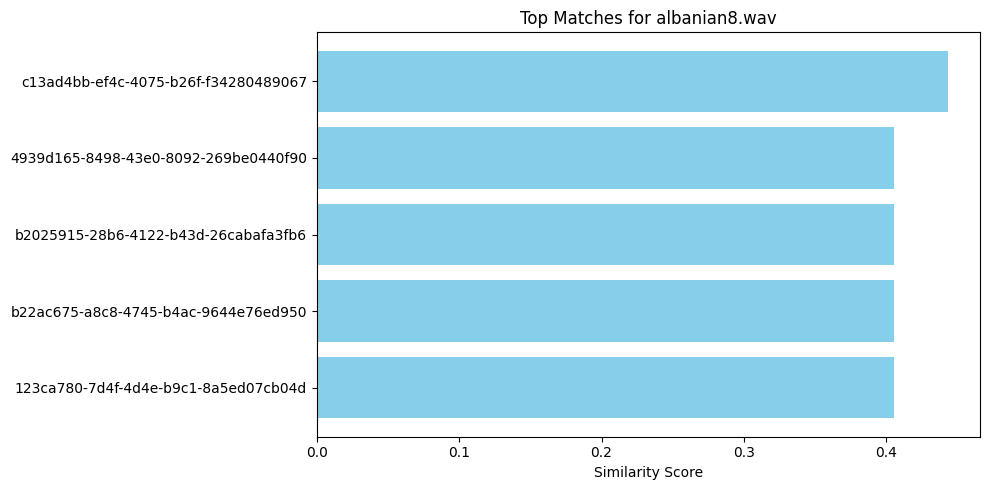

In [17]:
# import matplotlib.pyplot as plt

# def plot_similarity_scores(query_file: str, matches: list):
#     ids = [match['id'] for match in matches]
#     scores = [match['score'] for match in matches]

#     plt.figure(figsize=(10, 5))
#     plt.barh(ids[::-1], scores[::-1], color='skyblue')
#     plt.xlabel("Similarity Score")
#     plt.title(f"Top Matches for {query_file}")
#     plt.tight_layout()
#     plt.show()
# results = similarity_search(file_path, index, top_k=5)
# plot_similarity_scores(filename, results['matches'])


In [18]:
# from sklearn.decomposition import PCA
# import numpy as np

# def visualize_embeddings(embeddings, labels, method='pca'):
#     if method == 'pca':
#         reducer = PCA(n_components=2)
#     else:
#         from sklearn.manifold import TSNE
#         reducer = TSNE(n_components=2, perplexity=10)

#     reduced = reducer.fit_transform(embeddings)

#     plt.figure(figsize=(8, 6))
#     for i, label in enumerate(labels):
#         plt.scatter(reduced[i, 0], reduced[i, 1], label=label)
#     plt.title("2D Projection of Embeddings")
#     plt.xlabel("Dim 1")
#     plt.ylabel("Dim 2")
#     plt.legend(loc='best', fontsize='small')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [19]:
# import numpy as np
# import plotly.express as px
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# def interactive_visualize_embeddings(embeddings, labels, method='pca'):
#     """
#     Interactive 2D visualization of audio embeddings using PCA or t-SNE.

#     Args:
#         embeddings (ndarray): Numpy array of shape (n_samples, n_features).
#         labels (list): List of file names or labels.
#         method (str): 'pca' or 'tsne' for dimensionality reduction.
#     """
#     if method == 'pca':
#         reducer = PCA(n_components=2)
#     elif method == 'tsne':
#         reducer = TSNE(n_components=2, perplexity=5, random_state=42)
#     else:
#         raise ValueError("Method must be either 'pca' or 'tsne'.")

#     reduced = reducer.fit_transform(embeddings)

#     fig = px.scatter(
#         x=reduced[:, 0],
#         y=reduced[:, 1],
#         text=labels,
#         labels={'x': 'Component 1', 'y': 'Component 2'},
#         title=f'2D Visualization of Audio Embeddings using {method.upper()}',
#         hover_name=labels,
#     )
#     fig.update_traces(marker=dict(size=8, color='blue'), textposition='top center')
#     fig.update_layout(showlegend=False)
#     fig.show()
# interactive_visualize_embeddings(np.array(all_embeddings), labels, method='pca')


NameError: name 'all_embeddings' is not defined

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics.pairwise import cosine_similarity

# def plot_similarity_matrix(embeddings, labels, max_labels=30):
#     """
#     Plot a heatmap of cosine similarity between audio embeddings.

#     Args:
#         embeddings (ndarray): Array of shape (n_samples, embedding_dim).
#         labels (list): List of filenames/labels.
#         max_labels (int): Truncate to avoid overcrowding. Default = 30.
#     """
#     # Truncate if there are too many items
#     if len(labels) > max_labels:
#         embeddings = embeddings[:max_labels]
#         labels = labels[:max_labels]

#     # Compute cosine similarity
#     sim_matrix = cosine_similarity(embeddings)

#     # Plot
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels,
#                 cmap='viridis', annot=False, linewidths=0.5)
#     plt.title("Pairwise Audio Similarity (Cosine)", fontsize=14)
#     plt.xticks(rotation=45, ha='right')
#     plt.yticks(rotation=0)
#     plt.tight_layout()
#     plt.show()
# plot_similarity_matrix(np.array(all_embeddings), labels)


In [20]:
def verify_voice_similarity(reference_audio_path: str, test_audio_path: str, index, threshold: float = 0.75) -> bool:
    """
    Verifies whether the test voice matches the reference using embedding similarity.

    Args:
        reference_audio_path (str): Path to registered user's audio file.
        test_audio_path (str): Path to the recorded test audio.
        index: Pinecone index object.
        threshold (float): Similarity score threshold to determine a match.

    Returns:
        bool: True if match is found, False otherwise.
    """
    try:
        # Extract test audio embedding
        test_embedding = extract_embedding(test_audio_path)

        # Query Pinecone with test embedding
        results = index.query(
            vector=test_embedding.tolist(),
            top_k=1,
            include_metadata=True
        )

        # Reference ID from file name
        reference_id = os.path.basename(reference_audio_path).replace(".wav", "")

        if results and results.get('matches'):
            best_match = results['matches'][0]
            matched_id = best_match['id']
            score = best_match['score']

            print(f"🔍 Matched ID: {matched_id}, Score: {score:.4f}")

            return matched_id == reference_id and score >= threshold
        else:
            return False

    except Exception as e:
        print(f"❌ Error during verification: {str(e)}")
        return False
